In [ ]:
!pip install surprise sns joblib tensorflow scikit-learn pymongo ydata-profiling --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 77.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection.search import GridSearchCV
from pathlib import Path
from IPython.display import display,Markdown
import joblib
from tqdm import tqdm
import pickle
# from google.colab import output, 
# output.enable_custom_widget_manager()
from ydata_profiling import ProfileReport
from sklearn.preprocessing import MultiLabelBinarizer,OneHotEncoder
from sklearn.model_selection import train_test_split


from os import environ
import pymongo
import json
from subprocess import Popen

## 1. Exploración de los datasets

In [ ]:
yelp_path = Path("/content/drive/MyDrive/Colab Notebooks/Data/data/")

yelp_processed_data = Path("./processed_data/")

# ordenados por tamaño
yelp_business = Path(yelp_path,"yelp_academic_dataset_business.json")
yelp_tip = Path(yelp_path , "yelp_academic_dataset_tip.json")
yelp_checkin = Path(yelp_path , "yelp_academic_dataset_checkin.json")
yelp_user = Path(yelp_path , "yelp_academic_dataset_user.json")
yelp_review = Path(yelp_path , "yelp_academic_dataset_review.json")

In [ ]:
%%time
yelp_business_data = pd.read_json(yelp_business, lines=True) # 116 MB

CPU times: user 3.76 s, sys: 1.56 s, total: 5.31 s
Wall time: 6.72 s


In [ ]:
yelp_business_data.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [ ]:
%%time
yelp_review_data = pd.read_json(yelp_review, lines=True) # 5 GB

CPU times: user 1min 48s, sys: 1min 44s, total: 3min 33s
Wall time: 4min 10s


In [ ]:
yelp_review_data.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


In [ ]:
yelp_review_data['user_id'].describe()

count                    6990280
unique                   1987929
top       _BcWyKQL16ndpBdggh2kNA
freq                        3048
Name: user_id, dtype: object

In [ ]:
yelp_review_data['business_id'].describe()

count                    6990280
unique                    150346
top       _ab50qdWOk0DdB6XOrBitw
freq                        7673
Name: business_id, dtype: object

In [ ]:
yelp_review_data['stars'].describe()

count    6.990280e+06
mean     3.748584e+00
std      1.478705e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: stars, dtype: float64

<Axes: ylabel='Frequency'>

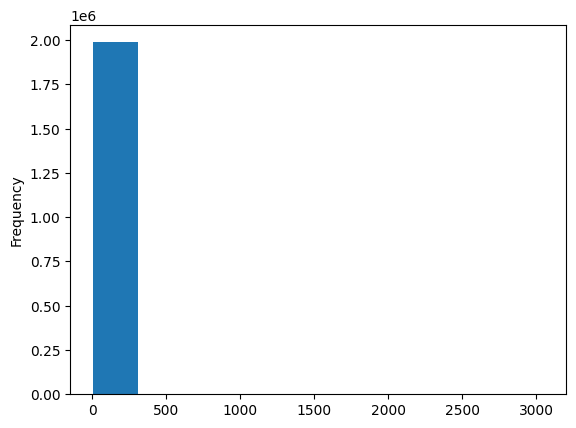

In [ ]:
yelp_review_data['user_id'].value_counts().plot.hist()

<Axes: ylabel='Frequency'>

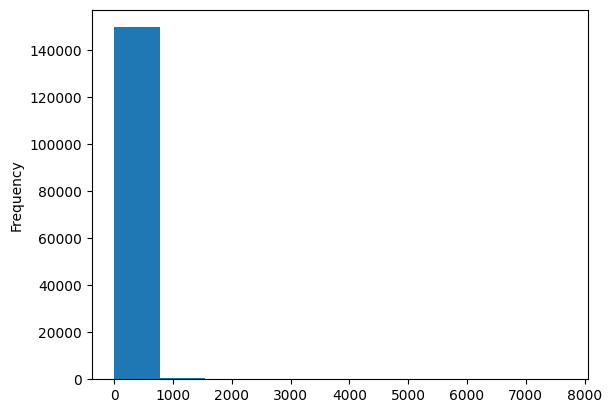

In [ ]:
yelp_review_data['business_id'].value_counts().plot.hist()

<Axes: ylabel='Frequency'>

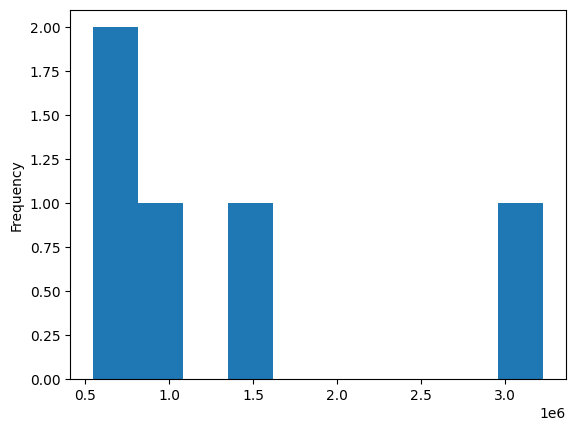

In [ ]:
yelp_review_data['stars'].value_counts().plot.hist()

In [ ]:
# Se establece el rango en el cual se aceptaran los ratings
reader = Reader( rating_scale = ( 1, 5 ) )

## 2. Transformación de los dataset al formato de Surprise

In [ ]:
# Assuming df is your DataFrame and it has columns 'user_id', 'business_id' and 'stars'
df_train, df_temp = train_test_split(yelp_review_data, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [ ]:
df_train.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
4763105,5xbDIl2IahpTufrr4M7M9A,V_46L2RMM2GrSorJMpOCkw,OJEiB_a2I_gxC-ZeayI94A,3,0,0,0,Visited the Another Broken Egg Cafe yesterday....,2019-03-20 14:59:49
3276572,r1bQOym6LOTHWZB3zd6Y0w,JGeVD5-0bKKnXnZxaTZUZQ,bRTWD05drzNfzVP0IadX7A,1,0,0,0,"I typically don't write reviews, but this plac...",2015-05-22 23:06:23
3769481,U23V0kEAYQ9QeuBpNqc0QA,VRKuCyuCYZGzCpMankWH1Q,232qg1k9QV0pNt90jyTatA,4,0,0,0,One of my goals for my New Orleans trip was to...,2017-11-17 10:23:07
1362927,Kk_TReiaS3CgIk_YoeZ5KQ,ohQzhkPJtKUmdAhHP6xZdw,Y5RUhntIPDfe2eKriQFIZg,5,0,0,0,Went here for the first time last night for dr...,2016-11-21 16:00:13
6976103,He83DqAVvvRgTM4JddlleQ,HVQKFDi-vZbawtmLMq3ZOw,0RuvlgTnKFbX3IK0ZOOocA,5,1,0,0,Green eggs cafe was amazing! My boyfriend and ...,2020-07-20 18:46:14


In [ ]:
# The columns must correspond to user id, item id and ratings (in that order).
data_train = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
data_val = Dataset.load_from_df(df_val[['user_id', 'business_id', 'stars']], reader)
data_test = Dataset.load_from_df(df_test[['user_id', 'business_id', 'stars']], reader)

In [ ]:
# Surprise requiere que explicitamente los datasets sean transformados a datasets de entrenamiento y prueba en cada caso 
# Si bien no se entrenará sobre los datasets de validación y prueba, surprise requiere que sean tranformados a entrenamiento para posteriormente ser transformados a prueba
train_data = data_train.build_full_trainset()
validation_data = data_val.build_full_trainset()
test_data = data_test.build_full_trainset()

In [ ]:
# Finalmente, se convierten los 3 datasets a prueba ya que se medirá el error obtenido en los 3
train_data_2 = train_data.build_testset()
validation_data = validation_data.build_testset()
test_data = test_data.build_testset()

## 3. Entrenamiento de un modelo SVD con bias

In [ ]:
mean = train_data.global_mean
print( mean )

3.7485801713236095


In [ ]:
gs_params = {
    # cambiar las k dimensiones
    "n_factors":list(range(35,45)),
    "reg_all":[0,0.01,1],
    "biased":[True],
    "lr_all":[0.01,0.1,0.5]
    }

svd = SVD( n_epochs = 200,init_mean = 0, init_std_dev = 0.01 )

gs_large = GridSearchCV(SVD, gs_params, measures=["rmse","mae"], cv=3,n_jobs=-1,return_train_measures=True,joblib_verbose=2)

In [ ]:
%%time
gs_large.fit(data_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 67.4min


CPU times: user 1h 35min 35s, sys: 6min 6s, total: 1h 41min 42s
Wall time: 2h 8min 35s


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 126.1min finished


In [ ]:
gs_large.best_params

{'rmse': {'n_factors': 36, 'reg_all': 0.01, 'biased': True, 'lr_all': 0.01},
 'mae': {'n_factors': 35, 'reg_all': 0.01, 'biased': True, 'lr_all': 0.01}}

In [ ]:
gs_large.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7f333c6b1c90>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7f333c6b0ca0>}

In [ ]:
best_model = gs_large.best_estimator['rmse']
best_model

In [ ]:
# Save the trained model
pickle.dump(best_model, open('/content/drive/MyDrive/Colab Notebooks/Data/model.pkl', 'wb'))

In [ ]:
trainset = data_train.build_full_trainset()
best_model.fit(trainset)

In [ ]:
# Get predictions for validation and test sets
predictions_validation = best_model.test(validation_data)
predictions_test = best_model.test(test_data)

# Then compute RMSE for both
rmse_validation = accuracy.rmse(predictions_validation)
rmse_test = accuracy.rmse(predictions_test)

print(f'Validation RMSE: {rmse_validation}')
print(f'Test RMSE: {rmse_test}')

RMSE: 1.3081
RMSE: 1.3082
Validation RMSE: 1.3081218201996487
Test RMSE: 1.308223600016433


In [ ]:
def get_all_predictions(user_id):
    # Get a list of all item ids
    iids = yelp_review_data['business_id'].unique()

    # Get a list of ids that the user has rated
    iids_user_rated = yelp_review_data.loc[yelp_review_data['user_id'] == user_id, 'business_id']

    # Remove the ids that the user has rated from the list of all item ids
    iids_to_pred = np.setdiff1d(iids, iids_user_rated)

    # Predict the rating for all items that the user hasn't rated yet
    predictions = [best_model.predict(user_id, iid) for iid in iids_to_pred]

    # return predictions in form of dataframe
    return pd.DataFrame(predictions)

In [ ]:
# Get all predictions for specific user
user_id = 'qVc8ODYU5SZjKXVBgXdI7w'  # replace with the user id you're interested in
all_predictions = get_all_predictions(user_id)

# Order the predictions from highest to lowest rated
ranked_predictions = all_predictions.sort_values(by='est', ascending=False)

# Print out the recommended items for the user
print(ranked_predictions)

                           uid                     iid  r_ui       est  \
52560   qVc8ODYU5SZjKXVBgXdI7w  LNv9jNMMU7-i-NxcLM5A3A  None  5.000000   
78476   qVc8ODYU5SZjKXVBgXdI7w  WTJrTbMgLHFwU8HPRFA7_Q  None  5.000000   
78462   qVc8ODYU5SZjKXVBgXdI7w  WStVCYmGWYtn1AZ_SvEDtQ  None  5.000000   
123671  qVc8ODYU5SZjKXVBgXdI7w  oklaxORZG7V0beWhEN_N8w  None  5.000000   
97073   qVc8ODYU5SZjKXVBgXdI7w  dRqRBDrQZsNKo72JlEcejw  None  5.000000   
...                        ...                     ...   ...       ...   
90388   qVc8ODYU5SZjKXVBgXdI7w  a_OkPbk51U7gCyArNEna0g  None  1.062890   
53637   qVc8ODYU5SZjKXVBgXdI7w  LreM6Gs1JUh3bY1hVhy7VA  None  1.028825   
109760  qVc8ODYU5SZjKXVBgXdI7w  io4YNLvABJrFraEwtQBWqA  None  1.015807   
106928  qVc8ODYU5SZjKXVBgXdI7w  hb4Viui0dPDUpFqN1PbRKA  None  1.000000   
104392  qVc8ODYU5SZjKXVBgXdI7w  gY4kIh8f9uCk-XI0FPH1fg  None  1.000000   

                          details  
52560   {'was_impossible': False}  
78476   {'was_impossible': False}  
784

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def get_top_n_similar(n, item_id, item_factors):
    # Fit nearest neighbors
    knn = NearestNeighbors(n_neighbors=n+1)  # +1 because the item is most similar to itself
    knn.fit(item_factors)
    
    # Get neighbors indices
    distances, indices = knn.kneighbors(item_factors[item_id].reshape(1, -1))
    
    # Exclude the item itself
    return indices[0][1:]

def get_top_n_similar_users(n, user_id, user_factors):
    # Fit nearest neighbors
    knn = NearestNeighbors(n_neighbors=n+1)  # +1 because the user is most similar to himself/herself
    knn.fit(user_factors)
    
    # Get neighbors indices
    distances, indices = knn.kneighbors(user_factors[user_id].reshape(1, -1))
    
    # Exclude the user itself
    return indices[0][1:]

In [ ]:
# Assume best_model is your trained SVD model
item_factors = best_model.qi
user_factors = best_model.pu

user_id = train_data.to_inner_uid('mh_-eMZ6K5RLWhZyISBhwA')

item_id = train_data.to_inner_iid('OJEiB_a2I_gxC-ZeayI94A')

# Get top 5 similar items for item with ID 10
similar_items = get_top_n_similar(5, 10, item_factors)
# Transform inner item IDs to raw item IDs
similar_items_raw = [train_data.to_raw_iid(i) for i in similar_items]
print(f"Top 5 similar items for item {train_data.to_raw_iid(item_id)}: {similar_items_raw}")

# Get top 5 similar users for user with ID 20
similar_users = get_top_n_similar_users(5, user_id, user_factors)
# Transform inner user IDs to raw user IDs
similar_users_raw = [train_data.to_raw_uid(i) for i in similar_users]
print(f"Top 5 similar users for user {train_data.to_raw_uid(user_id)}: {similar_users_raw}")

Top 5 similar items for item OJEiB_a2I_gxC-ZeayI94A: ['q4sI8dkd3QaGQ4qY-GQa2A', 'xDgIMuNfUrm72YZlBesUgg', 'r17TZ4H2vyptAV3nuydGsw', 'Ga2GyMUjrN7V0vhJVA-wBA', '0KEt5T4AlzHhGJXrgrJ1Ww']
Top 5 similar users for user mh_-eMZ6K5RLWhZyISBhwA: ['MCiWSAJcBHrXVFVslZqoTw', 'i4BA2SfIgj4CL7fJSefwqA', 'YXiERKhX7h5p2dBU24dcxg', '10ks1QgTTU9dfm8e2yt2vw', 'UwdN2diFAczEbSQXE7l4EQ']


In [63]:
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [ ]:
# Get predictions for validation and test sets
predictions_validation = best_model.test(validation_data)
predictions_test = best_model.test(test_data)

# Convert the predictions to lists of predicted business IDs
predicted_validation = [pred.iid for pred in predictions_validation]
predicted_test = [pred.iid for pred in predictions_test]

# Extract the actual business IDs from the validation and test sets
y_validation = [row[1] for row in validation_data]
y_test = [row[1] for row in test_data]

# Calculate the MRR for both
mrr_validation = mean_reciprocal_rank(y_validation, predicted_validation)
mrr_test = mean_reciprocal_rank(y_test, predicted_test)

print(f'Validation MRR: {mrr_validation}')
print(f'Test MRR: {mrr_test}')